In [12]:
import os 
import re
import glob 

import joblib
import pickle

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numpy import array
from pymongo import MongoClient
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import datetime,timedelta

import warnings 
warnings.filterwarnings(action='ignore')

import random

### 1.) Production & Result 업로드 

In [13]:
#df1 = pd.read_csv('ENGEL__Data/ENGEL_Production.csv',encoding='cp949')
df1 = pd.read_csv('C:/Production.csv',encoding='cp949')
df1['facility_cd'] = df1['facility_cd'].astype(str)

df1 = df1.drop_duplicates().reset_index(drop=True)
df_inputs = df1.loc[:, df1.columns.str.contains('shotdata_')]
unique_shot_cols = df_inputs.loc[:,df_inputs.apply(pd.Series.nunique) == 1].columns.tolist()
print(unique_shot_cols,' ==> Shot 변동 0회 제거 ')
df1 = df1.drop(unique_shot_cols,axis=1)
df1 = df1.drop(['param_inject_start_pos','facility_cd_pangdata'],axis=1)

################################################################################################################################

#df2 = pd.read_csv('ENGEL__Data/ENGEL_Result.csv',encoding='cp949')
df2 = pd.read_csv('C:/Result.csv',encoding='cp949')
#df2 = df2.dropna(subset=['cast_no']).reset_index(drop=True)

df2['facility_cd'] = df2['facility_cd'].astype(str)
df2['m_shotdata_no'] = df2['m_shotdata_no'].astype(int)
df2.rename(columns={'m_shotdatetime':'shotdatetime','m_shotdata_no':'shotdata_no'},inplace=True)
df2 = df2.drop_duplicates(subset=['facility_cd','item_cd','shotdata_no','shotdatetime']).reset_index(drop=True)

#### 추가 전처리 
df2[['good_qty_sum','bad_qty_sum']] = df2.groupby(['lot_no','cast_no'])[['good_qty','bad_qty']].transform('sum')
df2['qty_sum'] = df2['good_qty_sum'] + df2['bad_qty_sum']
df2[['seq_sum']] = df2.groupby(['lot_no','cast_no'])[['seq']].transform('count')
df2['cavity_count'] = np.floor(df2['qty_sum']/df2['seq_sum'])
df2['qty_(cavity)_equals_or_large'] = df2['seq_sum'] <= df2['qty_sum'] # shot 구성 cavity 배수 필터링 
df2 = df2[df2['qty_(cavity)_equals_or_large']==True].reset_index(drop=True)

df2 = df2.dropna(axis=1)
df2 = df2.dropna().reset_index(drop=True)
df2.shotdatetime = pd.to_datetime(df2.shotdatetime)
df2.shotdatetime = df2.shotdatetime.astype(object)
################################################################################################################################

df1.shape, df2.shape

[]  ==> Shot 변동 0회 제거 


((583519, 89), (565167, 42))

In [14]:
df1.shotdatetime

0         2023-12-01 08:30:50
1         2023-12-01 08:31:06
2         2023-12-01 08:32:15
3         2023-12-01 08:32:20
4         2023-12-01 08:33:34
                 ...         
583514    2024-08-31 07:20:24
583515    2024-08-31 07:21:32
583516    2024-08-31 07:22:39
583517    2024-08-31 07:23:48
583518    2024-08-31 07:24:57
Name: shotdatetime, Length: 583519, dtype: object

### 2.) 데이터 매칭 & Setting변동 기반 군집화 

In [24]:
df_merged = pd.merge(df1,df2,on=['plant_cd','facility_cd','shotdatetime','shotdata_no'],how='inner')
df_merged = df_merged.drop_duplicates()
df_merged.shotdatetime = pd.to_datetime(df_merged.shotdatetime)
df_merged = df_merged.dropna().reset_index(drop=True)

#### 추가 전처리 
#### Good & Bad Qty 동시 0개 / Good & Bad Qty 같은 개수 삭제 ( 학습 혼동 방지 )
df_merged = df_merged[(df_merged['good_qty']!=0.0) | (df_merged['bad_qty']!=0.0)].reset_index(drop=True) # 생산 없음 
#df_merged = df_merged[df_merged['good_qty']!=df_merged['bad_qty']].reset_index(drop=True)
df_merged['qty_fault_percentage'] = df_merged['bad_qty'] /(df_merged['good_qty'] + df_merged['bad_qty'])

#### Cavity 기준 1차 라벨링 
df_merged['PassOrFail'] = [1 if x > 0.0 else 0 for x in df_merged['qty_fault_percentage']]

#### lot & cavity 불량률 총계산
df_merged[['good_qty_sum','bad_qty_sum']] = df_merged.groupby(['facility_cd','item_cd','lot_no','cast_no'])[['good_qty','bad_qty']].transform('sum')
df_merged['qty_sum'] = df_merged['good_qty_sum'] + df_merged['bad_qty_sum']
df_merged[['seq_sum']] = df_merged.groupby(['facility_cd','item_cd','lot_no','cast_no'])[['seq']].transform('count')
df_merged['cavity_count'] = np.floor(df_merged['qty_sum']/df_merged['seq_sum'])
#df_merged['qty_(cavity)_equals_or_large'] = df_merged['seq_sum'] <= df_merged['qty_sum'] 
df_merged['lot_fault_ratio'] =  (df_merged['bad_qty_sum']/(df_merged['qty_sum']))*100
df_merged['cavity_fault_ratio'] = (df_merged['bad_qty'] /(df_merged['good_qty'] + df_merged['bad_qty']))*100

#### Setting기반 데이터 군집화 
set_cols = df_merged.loc[:,df_merged.columns.str.contains('param_')].columns 
for col in set_cols:
    try:
        df_merged[col] = df_merged[col].astype('float')
    except:
        df_merged[col] = df_merged[col].astype('float')
n = len(df_merged[set_cols].drop_duplicates()) # set_cols 
df_set = df_merged[set_cols]
pipe1 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=n, random_state=0))])
df_clustered_setting = pipe1.fit_predict(df_set)
df_merged['clusterSetting'] = df_clustered_setting
cluster_settings = df_merged['clusterSetting'].unique().tolist()
cluster_settings.sort()
print('Setting Clusters ==> ',len(cluster_settings))
#joblib.dump(pipe1,'KMeans/'+'Mold='+str(df_merged['facility_cd'].unique()[0].astype(int))+'_'+'Item='+str(df_merged['item_cd'].unique()[0])+'_cluster_setting.pkl')
#df_merged = df_merged[df_merged['clusterSetting']!=63].reset_index(drop=True)
df_merged.shape

Setting Clusters ==>  366


(432089, 132)

In [25]:
df_merged[set_cols].duplicated().value_counts()

True     431723
False       366
dtype: int64

[-13.404018  34.54573 ]


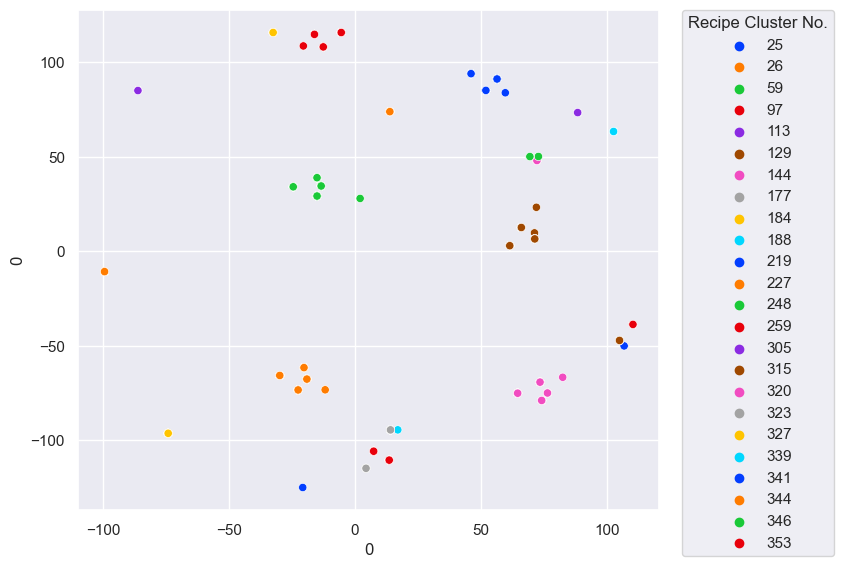

In [159]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

data = df_merged[set_cols].head(5000).reset_index(drop=True)
target = df_merged['clusterSetting'].head(5000).reset_index(drop=True)

n_components = 2
model = TSNE(n_components=n_components)
X_embedded = model.fit_transform(np.array(data))
print(X_embedded[0])

sns.set(font_scale=1.0)
plt.figure(figsize=(7.5,6.5))
plt.grid(True)
palette = sns.color_palette("bright",150) # bright
sns.scatterplot(x=pd.DataFrame(X_embedded[:,0])[0], y=pd.DataFrame(X_embedded[:,1])[0], hue=np.array(target),legend='full',palette=palette)
plt.legend(title='Recipe Cluster No.',bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0)
plt.show()

### 3.) 논문 실험용 설비&품목 선택 

In [26]:
#### 특정 Facility & Item 선택 
df_merged = df_merged[df_merged['facility_cd']=='2022'].reset_index(drop=True)
df_merged = df_merged[df_merged['item_cd']=='W-V802-00034D-A'].reset_index(drop=True)
df_merged['facility_cd'] = df_merged['facility_cd'].astype(int)

In [29]:
pd.set_option('display.max_rows',10)

In [27]:
input_cols = df_merged.loc[:,df_merged.columns.str.contains('shotdata_')].columns 
df_merged[input_cols].drop(['shotdata_no','shotdata_cycle_time'],axis=1).describe().iloc[1:]

,shotdata_inject_time,shotdata_switch_pos,shotdata_cushion_distance,shotdata_weight_time,shotdata_inject_max_press,shotdata_close_press_peak
mean,2.333264,13.465285,11.293054,24.101527,151.529759,13321.019238
std,0.080560,2.839415,2.722800,2.765662,2.524624,12.315604
min,2.190000,7.990000,5.880000,17.330000,118.730000,13260.500000
25%,2.300000,12.000000,9.810000,23.850000,149.910000,13312.600000
50%,2.340000,13.500000,11.390000,24.260000,151.400000,13323.000000
75%,2.350000,15.990000,13.690000,24.520000,153.170000,13330.400000
max,6.390000,21.000000,18.560000,172.030000,171.260000,13358.900000


### 4.) Lot 단위 Setting 변동 반영한 생산 불량률 정리 

In [31]:
pd.set_option('display.max_rows',None)

In [32]:
lot_fault_ratio = df_merged.groupby(['lot_no','clusterSetting'])[['lot_fault_ratio']].mean()
data_count = df_merged.groupby(['lot_no','clusterSetting'])[['shotdatetime']].count()
qty_sum = df_merged.groupby(['lot_no','clusterSetting'])[['good_qty_sum','bad_qty_sum']].mean()

In [33]:
df_summary = pd.concat([lot_fault_ratio,data_count,qty_sum],axis=1)
df_summary_normal = df_summary[(df_summary['lot_fault_ratio']==0.0)]
df_summary_fault = df_summary[(df_summary['lot_fault_ratio']>0.0)]

In [34]:
df_summary_normal

lot_fault_ratio  shotdatetime  good_qty_sum  \
lot_no   clusterSetting                                                
20240108 145                         0.0            31          31.0   
20240125 63                          0.0           862         862.0   
20240223 5                           0.0            48          49.0   
         6                           0.0             1          49.0   
20240225 182                         0.0           295         295.0   
20240226 166                         0.0            21         878.0   
         182                         0.0           857         878.0   
20240227 166                         0.0           414         414.0   
20240320 5                           0.0            14          14.0   
20240321 182                         0.0           222         222.0   
20240323 182                         0.0           892         892.0   
20240324 182                         0.0           807         807.0   
20240401 5                           0.0           465         465.0   
20240520 5                           0.0           739         739.0   
20240521 5                           0.0            76          76.0   
20240523 5                           0.0           105         105.0   
20240530 23                          0.0           136         136.0   
20240531 23                          0.0           118         118.0   
20240603 23                          0.0           550         550.0   
20240605 23                          0.0            87          87.0   
20240607 23                          0.0           151         151.0   
20240618 5                           0.0           299         299.0   
20240619 5                           0.0            36          36.0   
20240624 5                           0.0           294         294.0   
20240625 5                           0.0           342         342.0   
20240626 5                           0.0           236         236.0   
20240712 23                          0.0           181         181.0   
20240715 23                          0.0           262         262.0   
20240716 23                          0.0           511         511.0   

                         bad_qty_sum  
lot_no   clusterSetting               
20240108 145                     0.0  
20240125 63                      0.0  
20240223 5                       0.0  
         6                       0.0  
20240225 182                     0.0  
20240226 166                     0.0  
         182                     0.0  
20240227 166                     0.0  
20240320 5                       0.0  
20240321 182                     0.0  
20240323 182                     0.0  
20240324 182                     0.0  
20240401 5                       0.0  
20240520 5                       0.0  
20240521 5                       0.0  
20240523 5                       0.0  
20240530 23                      0.0  
20240531 23                      0.0  
20240603 23                      0.0  
20240605 23                      0.0  
20240607 23                      0.0  
20240618 5                       0.0  
20240619 5                       0.0  
20240624 5                       0.0  
20240625 5                       0.0  
20240626 5                       0.0  
20240712 23                      0.0  
20240715 23                      0.0  
20240716 23                      0.0

In [35]:
df_summary_fault

lot_fault_ratio  shotdatetime  good_qty_sum  \
lot_no   clusterSetting                                                
20231214 63                     1.369863           411         432.0   
         180                    1.369863            27         432.0   
20231215 63                     2.659574           752         732.0   
20231218 63                     1.515152            20          65.0   
         176                    1.515152            46          65.0   
20231219 176                    0.694444           288         286.0   
20240109 63                     2.245509           663         653.0   
         145                    2.245509             5         653.0   
20240110 63                     3.571429           401         729.0   
         147                    3.571429           355         729.0   
20240124 63                     0.293255           682         680.0   
20240126 63                     8.445946            48         271.0   
         79                     8.445946           140         271.0   
         244                    8.445946            97         271.0   
         311                    8.445946            10         271.0   
         357                    8.445946             1         271.0   
20240203 95                     0.946970           419         523.0   
         147                    0.946970            11         523.0   
         181                    0.946970            68         523.0   
         220                    0.946970             8         523.0   
         243                    0.946970             7         523.0   
         251                    0.946970             1         523.0   
         265                    0.946970             1         523.0   
         280                    0.946970             6         523.0   
         282                    0.946970             2         523.0   
         287                    0.946970             3         523.0   
         314                    0.946970             1         523.0   
         334                    0.946970             1         523.0   
20240204 95                     0.917431           162         216.0   
         162                    0.917431            23         216.0   
         172                    0.917431            30         216.0   
         247                    0.917431             3         216.0   
20240205 40                     0.323625           611         616.0   
         126                    0.323625             2         616.0   
         261                    0.323625             5         616.0   
20240206 40                     0.546448           732         728.0   
20240207 40                     0.250000           717         798.0   
         206                    0.250000             5         798.0   
         209                    0.250000            71         798.0   
         284                    0.250000             5         798.0   
         299                    0.250000             2         798.0   
20240224 5                      0.609756           137         815.0   
         182                    0.609756           683         815.0   
20240307 118                    0.411523           729         726.0   
20240308 118                    0.645995           774         769.0   
20240309 118                    1.112347           899         889.0   
20240310 118                    3.480278           431         416.0   
20240322 182                    0.514933           971         966.0   
20240402 5                      0.319489           313         312.0   
20240429 5                      0.879765           682         676.0   
20240430 5                      0.838323           835         828.0   
20240502 5                      0.611995           817         812.0   
20240503 5                      0.686499           874         868.0   
20240507 5                      1.902174           368         36

In [37]:
df_summary_fault_copy = df_summary_fault.copy()

### 5.) 학습데이터 구축 
- 불량률 0% Lot 

In [38]:
df_summary_normal = df_summary_normal.reset_index()
#df_summary_normal = df_summary_normal[ (df_summary_normal['lot_no']!=20240223) & (df_summary_normal['lot_no']!=20240226) ] 
df_summary_normal['Count'] = df_summary_normal['shotdatetime']
df_summary_normal = df_summary_normal.drop(['shotdatetime'],axis=1)
df_summary_normal

,lot_no,clusterSetting,lot_fault_ratio,good_qty_sum,bad_qty_sum,Count
0,20240108,145,0.0,31.0,0.0,31
1,20240125,63,0.0,862.0,0.0,862
2,20240223,5,0.0,49.0,0.0,48
3,20240223,6,0.0,49.0,0.0,1
4,20240225,182,0.0,295.0,0.0,295
5,20240226,166,0.0,878.0,0.0,21
6,20240226,182,0.0,878.0,0.0,857
7,20240227,166,0.0,414.0,0.0,414
8,20240320,5,0.0,14.0,0.0,14
9,20240321,182,0.0,222.0,0.0,222


In [39]:
df_summary_normal.groupby(['clusterSetting'])[['Count']].sum()

,Count
clusterSetting,
5,2654
6,1
23,1996
63,862
145,31
166,435
182,3073


In [40]:
df_normal = df_merged[df_merged['lot_fault_ratio']==0.0].reset_index(drop=True)
### --> 중복 Cluser lot 제거 
#df_normal = df_normal[ (df_normal['lot_no']!=20240223) & (df_normal['lot_no']!=20240226) ].reset_index(drop=True)

#conditions = [(normal_df['clusterSetting']==0) | (normal_df['clusterSetting']==3) | (normal_df['clusterSetting']==9) 
#& (normal_df['clusterSetting']==11) | (normal_df['clusterSetting']==14) | (normal_df['clusterSetting']==15)]

df_normal['clusterSetting'].value_counts()

182    3073
5      2654
23     1996
63      862
166     435
145      31
6         1
Name: clusterSetting, dtype: int64

### 6.) 테스트데이터 구축

#### 불량률 중복 발생한 Lot정보 전부 삭제 
- 불량이 어디서 발생했는지 정보가 불분명
- 개별 lot당 1개의 setting 추적 

In [41]:
pd.set_option('display.max_rows',None)

In [42]:
#### 불량률 중복인 setting값 가진 lot_no 삭제 
df_summary_fault_copy

lot_fault_ratio  shotdatetime  good_qty_sum  \
lot_no   clusterSetting                                                
20231214 63                     1.369863           411         432.0   
         180                    1.369863            27         432.0   
20231215 63                     2.659574           752         732.0   
20231218 63                     1.515152            20          65.0   
         176                    1.515152            46          65.0   
20231219 176                    0.694444           288         286.0   
20240109 63                     2.245509           663         653.0   
         145                    2.245509             5         653.0   
20240110 63                     3.571429           401         729.0   
         147                    3.571429           355         729.0   
20240124 63                     0.293255           682         680.0   
20240126 63                     8.445946            48         271.0   
         79                     8.445946           140         271.0   
         244                    8.445946            97         271.0   
         311                    8.445946            10         271.0   
         357                    8.445946             1         271.0   
20240203 95                     0.946970           419         523.0   
         147                    0.946970            11         523.0   
         181                    0.946970            68         523.0   
         220                    0.946970             8         523.0   
         243                    0.946970             7         523.0   
         251                    0.946970             1         523.0   
         265                    0.946970             1         523.0   
         280                    0.946970             6         523.0   
         282                    0.946970             2         523.0   
         287                    0.946970             3         523.0   
         314                    0.946970             1         523.0   
         334                    0.946970             1         523.0   
20240204 95                     0.917431           162         216.0   
         162                    0.917431            23         216.0   
         172                    0.917431            30         216.0   
         247                    0.917431             3         216.0   
20240205 40                     0.323625           611         616.0   
         126                    0.323625             2         616.0   
         261                    0.323625             5         616.0   
20240206 40                     0.546448           732         728.0   
20240207 40                     0.250000           717         798.0   
         206                    0.250000             5         798.0   
         209                    0.250000            71         798.0   
         284                    0.250000             5         798.0   
         299                    0.250000             2         798.0   
20240224 5                      0.609756           137         815.0   
         182                    0.609756           683         815.0   
20240307 118                    0.411523           729         726.0   
20240308 118                    0.645995           774         769.0   
20240309 118                    1.112347           899         889.0   
20240310 118                    3.480278           431         416.0   
20240322 182                    0.514933           971         966.0   
20240402 5                      0.319489           313         312.0   
20240429 5                      0.879765           682         676.0   
20240430 5                      0.838323           835         828.0   
20240502 5                      0.611995           817         812.0   
20240503 5                      0.686499           874         868.0   
20240507 5                      1.902174           368         36

In [43]:
df_summary_fault = df_summary_fault.reset_index()

df_summary_fault = df_summary_fault[(df_summary_fault['lot_no']!=20231214) & (df_summary_fault['lot_no']!=20231218) & (df_summary_fault['lot_no']!=20240109) & 
(df_summary_fault['lot_no']!=20240110) & (df_summary_fault['lot_no']!=20240126) & (df_summary_fault['lot_no']!=20240203) & 
(df_summary_fault['lot_no']!=20240204) & (df_summary_fault['lot_no']!=20240205) & (df_summary_fault['lot_no']!=20240207) & 
(df_summary_fault['lot_no']!=20240224)].reset_index(drop=True)


df_summary_fault['Count'] = df_summary_fault['shotdatetime']
df_summary_fault = df_summary_fault.drop(['shotdatetime'],axis=1)
df_summary_fault.groupby(['lot_no','clusterSetting'])[['lot_fault_ratio','good_qty_sum','bad_qty_sum','Count']].mean()

,,lot_fault_ratio,good_qty_sum,bad_qty_sum,Count
lot_no,clusterSetting,,,,
20231215,63,2.659574,732.0,20.0,752.0
20231219,176,0.694444,286.0,2.0,288.0
20240124,63,0.293255,680.0,2.0,682.0
20240206,40,0.546448,728.0,4.0,732.0
20240307,118,0.411523,726.0,3.0,729.0
20240308,118,0.645995,769.0,5.0,774.0
20240309,118,1.112347,889.0,10.0,899.0
20240310,118,3.480278,416.0,15.0,431.0
20240322,182,0.514933,966.0,5.0,971.0


In [44]:
df_fault = df_merged[df_merged['lot_fault_ratio']>0.0].reset_index(drop=True)

In [105]:
df_fault = df_merged[df_merged['lot_fault_ratio']>0.0].reset_index(drop=True)

df_fault = df_fault[(df_fault['lot_no']!=20231214) & (df_fault['lot_no']!=20231218) & (df_fault['lot_no']!=20240109) & 
(df_fault['lot_no']!=20240110) & (df_fault['lot_no']!=20240126) & (df_fault['lot_no']!=20240203) & 
(df_fault['lot_no']!=20240204) & (df_fault['lot_no']!=20240205) & (df_fault['lot_no']!=20240207) & 
(df_fault['lot_no']!=20240224)].reset_index(drop=True)

df_fault['clusterSetting'].value_counts()

5      5584
118    2833
63     1434
182     971
40      732
23      475
176     288
Name: clusterSetting, dtype: int64

### 7.)최종 Test용 불량 정보 확인 

In [107]:
df_fault.groupby(['lot_no','clusterSetting'])[['lot_fault_ratio','good_qty_sum','bad_qty_sum']].mean()

,,lot_fault_ratio,good_qty_sum,bad_qty_sum
lot_no,clusterSetting,,,
20231215,63,2.659574,732.0,20.0
20231219,176,0.694444,286.0,2.0
20240124,63,0.293255,680.0,2.0
20240206,40,0.546448,728.0,4.0
20240307,118,0.411523,726.0,3.0
20240308,118,0.645995,769.0,5.0
20240309,118,1.112347,889.0,10.0
20240310,118,3.480278,416.0,15.0
20240322,182,0.514933,966.0,5.0


### 8.) Train / Test 데이터 저장

In [109]:
df_normal.shape, df_fault.shape

((9052, 132), (12317, 132))

In [110]:
df_normal.to_csv('Train.csv',encoding='cp949',index=False)

In [111]:
df_fault.to_csv('Test.csv',encoding='cp949',index=False)